# MCMC: Slice sampling

Florent Leclercq,<br/>
Institute of Cosmology and Gravitation, University of Portsmouth,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm, cauchy
from math import pi
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

## Slice sampling tutorial

### 1- Drawing y

Starting from an initial x, we draw y uniformly in $[0,f(x)]$.

In [2]:
gaussian=norm(0,1)
x=1.3
f_of_x=gaussian.pdf(x)
y=np.random.uniform(0.,f_of_x)

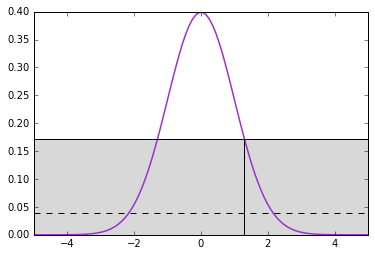

In [3]:
x_arr=np.linspace(-5,5,100)
plt.xlim(-5,5)
plt.plot(x_arr,gaussian.pdf(x_arr),color='darkorchid',linewidth=1.5)
plt.plot([x,x],[0,f_of_x],color='black')
plt.plot([-5,5],[f_of_x,f_of_x],color='black')
plt.plot([-5,5],[y,y],color='black',linestyle='--')
plt.fill_between([-5,5],0.,f_of_x,facecolor='grey',alpha=0.3, linewidth=0.)
plt.show()

### 2- Drawing x

We draw y uniformly in the "slice" where $f(x)\geq y$. In the case of the Gaussian distribution $G(0,1)$, this is drawing $x$ uniformly in $[-x_0,x_0]$ where $x_0=\sqrt{-2 \ln(y \sqrt{2\pi})}$.

In [4]:
x0=np.sqrt(-2*np.log(y*np.sqrt(2*pi)))
x_new=np.random.uniform(-x0,x0)

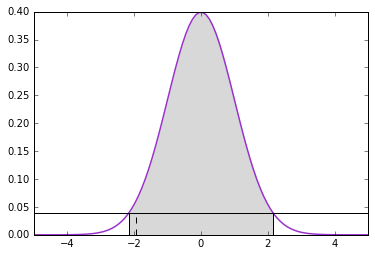

In [5]:
x_arr=np.linspace(-5,5,100)
x_slice_arr=np.linspace(-x0,x0,100)
plt.xlim(-5,5)
plt.plot(x_arr,gaussian.pdf(x_arr),color='darkorchid',linewidth=1.5)
plt.plot([-5,5],[y,y],color='black')
plt.plot([x0,x0],[0.,y],color='black')
plt.plot([-x0,-x0],[0.,y],color='black')
plt.plot([x_new,x_new],[0.,y],color='black',linestyle='--')
plt.fill_between(x_slice_arr,0.,gaussian.pdf(x_slice_arr),facecolor='grey',alpha=0.3, linewidth=0.)
plt.show()

### 3- Iterate!

In [6]:
def slice_sampler_gaussian(Nsteps,x_start):
    Naccepted=0
    samples=np.zeros(Nsteps+1)
    samples[0]=x_start
    x=x_start
    for i in xrange(Nsteps):
        f_of_x=gaussian.pdf(x)
        y=np.random.uniform(0.,f_of_x)
        x0=np.sqrt(-2*np.log(y*np.sqrt(2*pi)))
        x_p=np.random.uniform(-x0,x0)
        a = min(1, gaussian.pdf(x_p)/gaussian.pdf(x))
        u = np.random.uniform()
        if u < a:
            Naccepted+=1
            x=x_p
        samples[i+1]=x
    return Naccepted,samples

In [7]:
x_start=2.
Nsteps=99
Naccepted,samples=slice_sampler_gaussian(Nsteps,x_start)

In [8]:
fraction_accepted=float(Naccepted)/Nsteps
fraction_accepted

0.8181818181818182

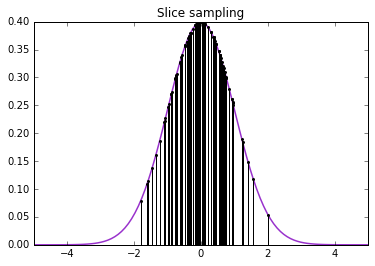

In [9]:
plt.xlim(-5,5)
plt.plot(x_arr,gaussian.pdf(x_arr),color='darkorchid',linewidth=1.5)
markerline, stemlines, baseline = plt.stem(samples,gaussian.pdf(samples))
plt.setp(markerline, color='black', markersize=3., markeredgewidth = 0.)
plt.setp(stemlines, color='black')
plt.title("Slice sampling")
plt.show()

## Slice sampling in practice and multimodal distributions

In [10]:
def target_pdf(x):
    return cauchy(scale=0.5,loc=0.8).pdf(x)+0.5*norm(2.8,0.3).pdf(x)
target_pdf=np.vectorize(target_pdf)

In [11]:
a=-2.
b=5.
x_arr=np.linspace(a,b,200.)
f_arr=target_pdf(x_arr)

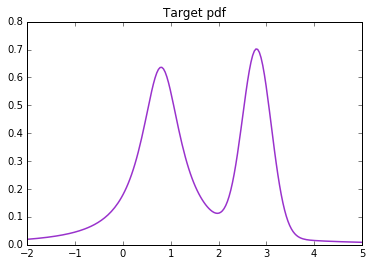

In [12]:
plt.xlim(a,b)
plt.plot(x_arr,f_arr,color='darkorchid',linewidth=1.5)
plt.title("Target pdf")
plt.show()

In [13]:
def slice_sampler(target_pdf,Nsteps,x_start,x_width):
    Naccepted=0
    samples=np.zeros(Nsteps+1)
    samples[0]=x_start
    x=x_start
    for i in xrange(Nsteps):
        y=np.random.uniform(0, target_pdf(x))
        lb=x
        rb=x
        # we build the approximate slice by expanding around the current x
        while y<target_pdf(lb):
            lb-=x_width
        while y<target_pdf(rb):
            rb+=x_width
        # we draw a new x
        x_p=np.random.uniform(lb,rb)
        if target_pdf(x_p)>y:
            # x_p was in the slice, we keep it as a proposed sample
            a = min(1, target_pdf(x_p)/target_pdf(x))
            u = np.random.uniform()
            if u < a:
                Naccepted+=1
                x=x_p
            samples[i+1]=x
        else:
            # x was not in the slice, we adjust the boundaries of the approximate slice
            if np.abs(x-lb)<np.abs(x-rb):
                lb = x
            else:
                rb = x
    return Naccepted,samples

In [14]:
x_width=0.5 # a good width to explore the multimodal distribution
Nsteps=150
x_start=3.2
Naccepted,samples=slice_sampler(target_pdf,Nsteps,x_start,x_width)

In [15]:
fraction_accepted=float(Naccepted)/Nsteps
fraction_accepted

0.6066666666666667

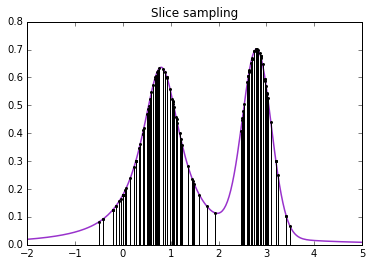

In [16]:
plt.xlim(a,b)
plt.plot(x_arr,f_arr,color='darkorchid',linewidth=1.5)
markerline, stemlines, baseline = plt.stem(samples,target_pdf(samples))
plt.setp(markerline, color='black', markersize=3., markeredgewidth = 0.)
plt.setp(stemlines, color='black')
plt.title("Slice sampling")
plt.show()

## Two-dimensional slice sampling

### The target pdf

In [17]:
def target_joint(x,y):
    return x*x * np.exp(-x*y*y -y*y +2.*y -4.*x)
def target_marginal_x(x):
    return x*x/np.sqrt(x+1) * np.exp(-4.*x -1./(x+1.))
def target_marginal_y(y):
    return np.exp(-y*y+2.*y) / (y*y+4.)**3

In [18]:
# Normalization of the marginals
Nx=quad(target_marginal_x,0.0001,100.)[0]
Ny=quad(target_marginal_y,-100.,100.)[0]

In [19]:
xmin=0.
xmax=2.
ymin=-1.
ymax=2.5
x=np.linspace(xmin,xmax,1000)
y=np.linspace(ymin,ymax,1000)
X,Y=np.meshgrid(x,y)
Z=target_joint(X,Y)

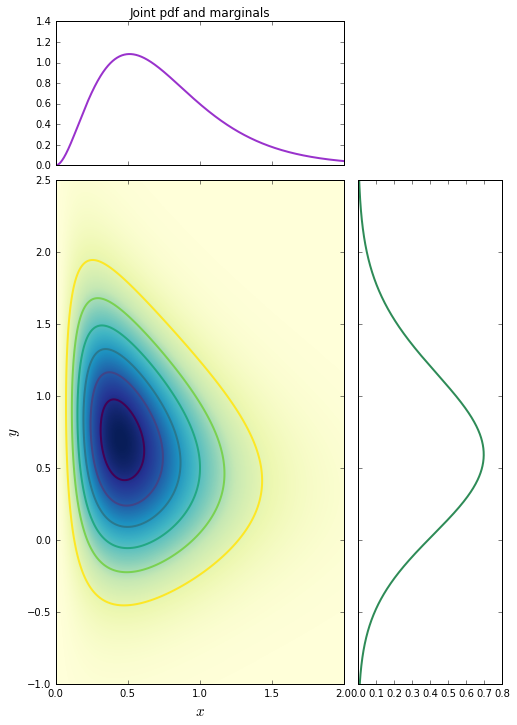

In [20]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.1
bottom_h = bottom + height + 0.1

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$",size=15)
ax.set_ylabel("$y$",size=15)
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',linewidths=2,cmap='viridis_r')

axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim(0,1.4)
axpdfx.plot(x,target_marginal_x(x)/Nx,linewidth=2.,color='darkorchid')

axpdfy.set_xlim(0,0.8)
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,linewidth=2.,color='seagreen')

axpdfx.set_title("Joint pdf and marginals")
plt.show()

### The sampler

In [21]:
def slice_sampler_2D(target_pdf,Nsteps,x_start,xmin,xmax,y_start,ymin,ymax):
    Naccepted=0
    samples_x=np.zeros(Nsteps+1)
    samples_y=np.zeros(Nsteps+1)
    samples_x[0]=x_start
    samples_y[0]=y_start
    x=x_start
    y=y_start
    for i in xrange(Nsteps):
        z=np.random.uniform(0, target_pdf(x,y))
        
        # we draw a new (x,y) uniformly in the rectangle ([xmin,xmax],[ymin,ymax])
        # this may be inefficient. alternatively, one could adaptively define a 2D rectangle
        # (cf. hyperrectangle slice sampling)
        x_p=np.random.uniform(xmin,xmax)
        y_p=np.random.uniform(ymin,ymax)
        # we keep only points that are in the slice
        while target_pdf(x_p,y_p)<z:
            x_p=np.random.uniform(xmin,xmax)
            y_p=np.random.uniform(ymin,ymax)

        # (x_p,y_p) was in the slice, we keep it as a proposed sample
        a = min(1, target_pdf(x_p,y_p)/target_pdf(x,y))
        u = np.random.uniform()
        if u < a:
            Naccepted+=1
            x=x_p
            y=y_p
        samples_x[i+1]=x
        samples_y[i+1]=y
    return Naccepted,samples_x,samples_y

In [22]:
Nsteps=2000
x_start=1.8
y_start=1.4
Naccepted,samples_x,samples_y=slice_sampler_2D(target_joint,Nsteps,x_start,xmin,xmax,y_start,ymin,ymax)

In [23]:
fraction_accepted=float(Naccepted)/Nsteps
fraction_accepted

0.761

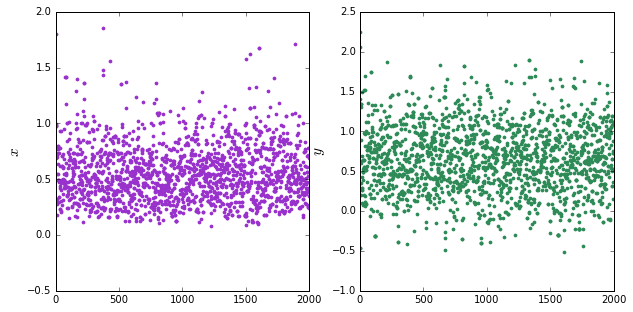

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_xlim(0,Nsteps)
ax1.set_ylabel("$x$",size=15)
ax1.scatter(np.arange(Nsteps+1),samples_x,color='darkorchid',marker='.',linewidth=1.5)
ax2.set_xlim(0,Nsteps)
ax2.set_ylabel("$y$",size=15)
ax2.scatter(np.arange(Nsteps+1),samples_y,color='seagreen',marker='.',linewidth=1.5)
plt.show()

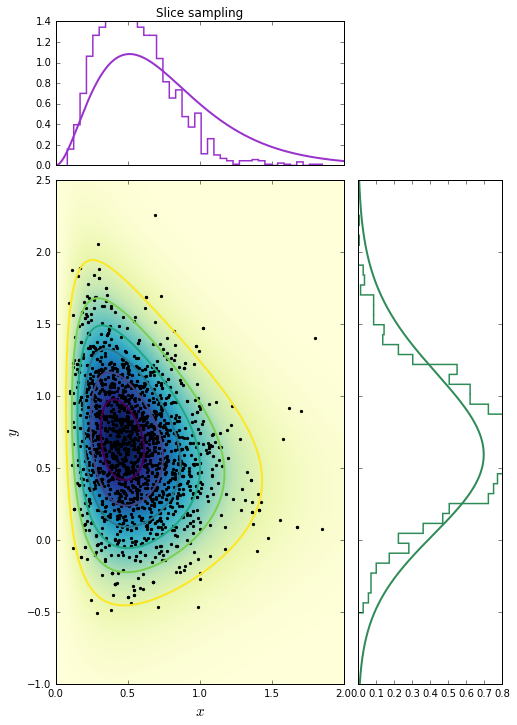

In [25]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
left_h = left + width + 0.1
bottom_h = bottom + height + 0.1

rect_pdf = [left, bottom, width, height]
rect_pdfx = [left, bottom_h, width, 1.]
rect_pdfy = [left_h, bottom, 1., height]

# start with a rectangular Figure
plt.figure(1, figsize=(2, 2))

ax = plt.axes(rect_pdf)
axpdfx = plt.axes(rect_pdfx)
axpdfy = plt.axes(rect_pdfy)

# no labels
axpdfx.xaxis.set_major_formatter(nullfmt)
axpdfy.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$",size=15)
ax.set_ylabel("$y$",size=15)
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',linewidths=2,cmap='viridis_r')
ax.scatter(samples_x,samples_y,marker='.',color='black')

axpdfx.set_xlim(xmin,xmax)
axpdfx.set_ylim(0,1.4)
axpdfx.plot(x,target_marginal_x(x)/Nx,linewidth=2.,color='darkorchid')
axpdfx.hist(samples_x,40,normed=True,histtype='step',color='darkorchid',linewidth=1.5)

axpdfy.set_xlim(0,0.8)
axpdfy.set_ylim(ymin,ymax)
axpdfy.plot(target_marginal_y(y)/Ny,y,linewidth=2.,color='seagreen')
axpdfy.hist(samples_y,40,normed=True,histtype='step',color='seagreen',linewidth=1.5,orientation='horizontal')

axpdfx.set_title("Slice sampling")
plt.show()